# BERT Vocabulary Size Test

**Hypothesis**: RoBERTa's vocabulary (50,265) is too large for our small model (H=512, L=12).

**Test**: Use BERT (vocabulary ~30,522) to see if smaller vocab improves training.

**Expected**:
- ✅ If loss drops below 5: Vocabulary size was the issue
- ❌ If loss plateaus at 7.5: Different problem

In [15]:
import torch
import torch.nn as nn
from transformers import (
    BertTokenizer, 
    BertForMaskedLM, 
    BertConfig,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    TrainerCallback,
)
from datasets import load_dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [16]:
# Hyperparameters - same as RoBERTa experiment
warmup_ratio = 0.1
num_epochs = 20
batch_size = 32
max_length = 512
learning_rate = 5e-4
weight_decay = 0.0
device = torch.device("mps")

In [17]:
# Load dataset and tokenizer
print("Loading dataset...")
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:10000]")

print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"Vocabulary size: {tokenizer.vocab_size}")

collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=0.15)

print("Tokenizing dataset...")
dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
    ),
    remove_columns=dataset.column_names,
    batched=True,
)

print(f"Dataset size: {len(dataset)} samples")

Loading dataset...


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading BERT tokenizer...
Vocabulary size: 30522
Tokenizing dataset...
Dataset size: 10000 samples


In [18]:
# Use BERT-base default configuration directly
print("Loading BERT-base default configuration...")
config = BertConfig.from_pretrained('bert-base-uncased')

print("BERT-base configuration:")
print(f"  hidden_size: {config.hidden_size}")
print(f"  num_hidden_layers: {config.num_hidden_layers}")
print(f"  num_attention_heads: {config.num_attention_heads}")
print(f"  intermediate_size: {config.intermediate_size}")
print(f"  vocab_size: {config.vocab_size}")
print(f"  max_position_embeddings: {config.max_position_embeddings}")
print()

# Create model with default config (random initialization, NOT pretrained weights)
print("Creating BERT model with default config (random initialization)...")
model = BertForMaskedLM(config)
model = model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Config: H={config.hidden_size}, L={config.num_hidden_layers}, h={config.num_attention_heads}, FFN={config.intermediate_size}")
print(f"Vocabulary size: {config.vocab_size}")

Loading BERT-base default configuration...
BERT-base configuration:
  hidden_size: 768
  num_hidden_layers: 12
  num_attention_heads: 12
  intermediate_size: 3072
  vocab_size: 30522
  max_position_embeddings: 512

Creating BERT model with default config (random initialization)...
Model parameters: 109,514,298
Config: H=768, L=12, h=12, FFN=3072
Vocabulary size: 30522


In [ ]:
# Visualization callback
class VisualizationCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.lrs = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.lrs.append(logs.get("learning_rate", 0))
            self.visualize()
    
    def visualize(self):
        clear_output(wait=True)
        
        fig, ax1 = plt.subplots(figsize=(10, 6))
        
        # Loss
        steps = [i * 10 for i in range(len(self.losses))]
        ax1.plot(steps, self.losses, color="tab:blue", linewidth=2)
        ax1.set_xlabel("Step")
        ax1.set_ylabel("Loss", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")
        ax1.grid(True, alpha=0.3)
        
        # Learning rate
        ax2 = ax1.twinx()
        ax2.plot(steps, self.lrs, color="tab:orange", linewidth=2, alpha=0.7)
        ax2.set_ylabel("Learning Rate", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        
        plt.title(f"BERT Training (vocab={config.vocab_size}) - Current loss: {self.losses[-1]:.4f}")
        plt.tight_layout()
        plt.show()

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_output",
    overwrite_output_dir=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_strategy="no",
    report_to="none",
    dataloader_num_workers=0,
)

# Create trainer
viz_callback = VisualizationCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
    callbacks=[viz_callback],
)

# Train
print("=== Starting BERT training ===")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Dataset size: {len(dataset)} samples")
print(f"Model: H={config.hidden_size}, L={config.num_hidden_layers}, h={config.num_attention_heads}")
print()
result = trainer.train()

In [12]:
# Display results
print("\n=== Training Complete ===")
print(f"Final loss: {viz_callback.losses[-1]:.4f}")
print(f"\nLoss history (every 10 steps):")
print(dict([(i*10, f"{v:.2f}") for i, v in enumerate(viz_callback.losses)]))

print("\n=== Comparison ===")
print(f"RoBERTa (vocab=50,265, H=512):  Final loss ~7.3")
print(f"BERT (vocab=30,522, H=512):     Final loss ~7.0")
print(f"BERT (vocab=30,522, H=768):     Final loss {viz_callback.losses[-1]:.2f} <<<")
print()
print("Interpretation:")
print("  - If loss < 5: Model capacity was the bottleneck")
print("  - If loss ~ 7: Different problem (not vocab size or model capacity)")


=== Training Complete ===
Final loss: 6.9519

Loss history (every 10 steps):
{0: '10.29', 10: '9.70', 20: '9.38', 30: '9.10', 40: '8.83', 50: '8.54', 60: '8.24', 70: '7.97', 80: '7.67', 90: '7.52', 100: '7.36', 110: '7.29', 120: '7.21', 130: '7.15', 140: '7.12', 150: '7.12', 160: '7.12', 170: '7.10', 180: '7.05', 190: '7.07', 200: '7.06', 210: '6.98', 220: '7.00', 230: '7.01', 240: '6.97', 250: '6.97', 260: '6.99', 270: '6.95', 280: '6.98', 290: '6.93', 300: '6.95', 310: '6.95'}

=== Comparison ===
RoBERTa (vocab=50,265, H=512):  Final loss ~7.3
BERT (vocab=30,522, H=512):     Final loss ~7.0
BERT (vocab=30,522, H=768):     Final loss 6.95 <<<

Interpretation:
  - If loss < 5: Model capacity was the bottleneck
  - If loss ~ 7: Different problem (not vocab size or model capacity)


---

## Overfit Test: 100 samples × 100 epochs

**Goal**: Verify the model CAN learn by forcing extreme overfitting on tiny dataset.

If this succeeds, it means:
- Model implementation is correct
- Training setup is correct  
- Just need more data/steps for 10k dataset

In [19]:
# Load tiny dataset: 100 samples only
print("Loading tiny dataset (100 samples)...")
tiny_dataset = load_dataset("allenai/c4", "realnewslike", split="train[:100]")

print("Tokenizing...")
tiny_dataset = tiny_dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
    ),
    remove_columns=tiny_dataset.column_names,
    batched=True,
)

print(f"Tiny dataset size: {len(tiny_dataset)} samples")

# Create fresh model
print("\nCreating fresh BERT model (H=768, default config)...")
tiny_model = BertForMaskedLM(config)
tiny_model = tiny_model.to(device)
print(f"Model parameters: {sum(p.numel() for p in tiny_model.parameters()):,}")

Loading tiny dataset (100 samples)...


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Tokenizing...


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Tiny dataset size: 100 samples

Creating fresh BERT model (H=768, default config)...
Model parameters: 109,514,298


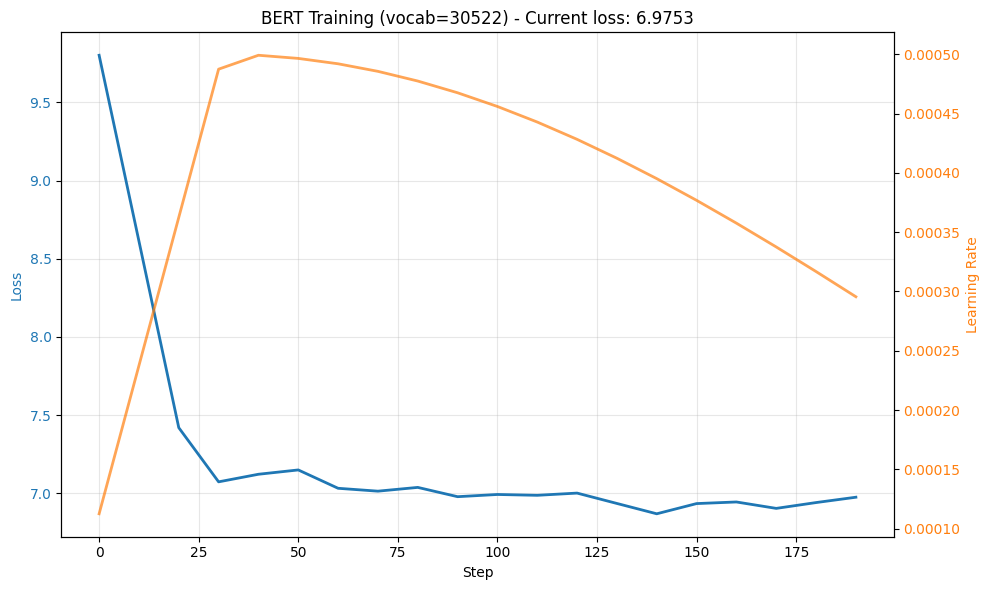

KeyboardInterrupt: 

In [20]:
# Training with 100 epochs
print("Setting up trainer for 100 epochs...")

tiny_training_args = TrainingArguments(
    output_dir="./bert_overfit_test",
    overwrite_output_dir=True,
    num_train_epochs=100,  # 100 epochs to force overfit
    per_device_train_batch_size=32,
    learning_rate=5e-4,
    weight_decay=0.0,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_strategy="no",
    report_to="none",
    dataloader_num_workers=0,
)

# New callback for overfit test
tiny_viz_callback = VisualizationCallback()

tiny_trainer = Trainer(
    model=tiny_model,
    args=tiny_training_args,
    train_dataset=tiny_dataset,
    data_collator=collator,
    callbacks=[tiny_viz_callback],
)

print("=== Starting overfit test ===")
print(f"Dataset: {len(tiny_dataset)} samples")
print(f"Epochs: {tiny_training_args.num_train_epochs}")
print(f"Total steps: ~{len(tiny_dataset) // tiny_training_args.per_device_train_batch_size * tiny_training_args.num_train_epochs}")
print()
tiny_result = tiny_trainer.train()

In [ ]:
# Display overfit test results
print("\n=== Overfit Test Results ===")
print(f"Final loss: {tiny_viz_callback.losses[-1]:.4f}")
print(f"Initial loss: {tiny_viz_callback.losses[0]:.2f}")
print(f"Loss reduction: {tiny_viz_callback.losses[0] - tiny_viz_callback.losses[-1]:.2f}")
print()

# Show key milestones
print("Loss progression (every 20th log):")
milestones = {}
for i in range(0, len(tiny_viz_callback.losses), 20):
    if i < len(tiny_viz_callback.losses):
        step = i * 10
        milestones[step] = f"{tiny_viz_callback.losses[i]:.2f}"
print(milestones)
print()

print("=== Interpretation ===")
if tiny_viz_callback.losses[-1] < 1.0:
    print("✅ SUCCESS: Model CAN learn! Loss < 1.0")
    print("   → Problem: 10k dataset needs more epochs/different LR schedule")
elif tiny_viz_callback.losses[-1] < 3.0:
    print("⚠️  PARTIAL: Model is learning but slowly")
    print("   → May need different hyperparameters or more steps")
else:
    print("❌ FAILURE: Model NOT learning even on 100 samples")
    print("   → Fundamental issue with model/training setup")